Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. We have tested this notebook on a server with 4 NVidia V100 GPU (32GB) and 400GB CPU Ram.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `nlp,ray,notebook` and `blendsearch` option:
```bash
pip install flaml[nlp,ray,notebook,blendsearch];
```

In [1]:
!pip install flaml[nlp,ray,notebook,blendsearch];

Let's run some examples. 

Note: throughout this notebook, you may see a few ModuleNotFoundErrors. As long as the cell successfully executes, you can ignore that error.

## 2. Sentiment Classification Example
### Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas().iloc[:10000]
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas().iloc[:10000]
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [2]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init() 

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-03-19 13:59:38,805	ERROR services.py:1421 -- Failed to start the dashboard: Failed to start the dashboard, return code 1
Failed to read dashboard log: [Errno 2] No such file or directory: '/tmp/ray/session_2022-03-19_13-59-37_048935_85869/logs/dashboard.log'
(raylet) Traceback (most recent call last):
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/agent.py", line 21, in <module>
(raylet)     import ray.dashboard.utils as dashboard_utils
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/utils.py", line 15, in <module>
(raylet)     import aioredis  # noqa: F401
(raylet) ModuleNotFoundError: No module named '

In [4]:

automl_settings = {
    "time_budget": 500,                  # setting the time budget
    "task": "seq-classification",       # setting the task as seq-classification
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   # setting the output directory
            "ckpt_per_epoch": 1,            # setting the number of checkoints per epoch
            "model_path": "google/electra-base-discriminator",  # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
            "per_device_eval_batch_size": 16   # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": True,                    # set whether to use Ray
    "n_concurrent_trials": 4,
    "keep_search_state": True,          # keeping the search state
}

In [5]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86265) {'loss': 0.688, 'learning_rate': 5.91472422187606e-05, 'epoch': 6.0}
(train pid=86265) {'eval_loss': 0.6975926160812378, 'eval_automl_metric': 0.49082568807339455, 'eval_runtime': 0.9885, 'eval_samples_per_second': 882.13, 'eval_steps_per_second': 55.639, 'epoch': 6.0}
(train pid=86265) {'eval_loss': 0.6959978938102722, 'eval_automl_metric': 0.49082568807339455, 'eval_runtime': 0.9612, 'eval_samples_per_second': 907.223, 'eval_steps_per_second': 57.222, 'epoch': 6.04}
(train pid=86255) {'loss': 0.133, 'learning_rate': 1.9966093201540806e-05, 'epoch': 3.0}
(train pid=86255) {'eval_loss': 0.29954516887664795, 'eval_automl_metric': 0.06880733944954132, 'eval_runtime': 0.9772, 'eval_samples_per_second': 892.372, 'eval_steps_per_second': 56.285, 'epoch': 3.0}
(train pid=86265) {'eval_loss': 0.6959978938102722, 'eval_automl_metric': 0.49082568807339455, 'eval_runtime': 0.9707, 'eval_samples_per_second': 898.292, 'eval_steps_per_second': 56.658, 'epoch': 6.04}
(train pid=862

(train pid=86265) Using amp half precision backend
(train pid=86265) ***** Running Prediction *****
(train pid=86265)   Num examples = 872
(train pid=86265)   Batch size = 16


(train pid=86211) {'loss': 0.2158, 'learning_rate': 5.454224012822699e-06, 'epoch': 3.0}
(train pid=86211) {'eval_loss': 0.21694229543209076, 'eval_automl_metric': 0.06422018348623848, 'eval_runtime': 0.9902, 'eval_samples_per_second': 880.648, 'eval_steps_per_second': 55.545, 'epoch': 3.0}
(train pid=86269) {'eval_loss': 0.5855236649513245, 'eval_automl_metric': 0.18463302752293576, 'eval_runtime': 0.9877, 'eval_samples_per_second': 882.845, 'eval_steps_per_second': 55.684, 'epoch': 4.53}
(train pid=86269) {'train_runtime': 373.6856, 'train_samples_per_second': 121.13, 'train_steps_per_second': 15.144, 'train_loss': 0.4671156674776214, 'epoch': 4.53}


(train pid=86269) Using amp half precision backend
(train pid=86269) ***** Running Prediction *****
(train pid=86269)   Num examples = 872
(train pid=86269)   Batch size = 16


(train pid=86255) {'loss': 0.0655, 'learning_rate': 1.1451941740938257e-05, 'epoch': 4.01}
(train pid=86255) {'eval_loss': 0.32505378127098083, 'eval_automl_metric': 0.06307339449541283, 'eval_runtime': 0.9623, 'eval_samples_per_second': 906.171, 'eval_steps_per_second': 57.155, 'epoch': 4.01}
(train pid=86211) {'loss': 0.1585, 'learning_rate': 4.673980815375941e-06, 'epoch': 4.01}
(train pid=86211) {'eval_loss': 0.26288139820098877, 'eval_automl_metric': 0.06422018348623848, 'eval_runtime': 0.9914, 'eval_samples_per_second': 879.599, 'eval_steps_per_second': 55.479, 'epoch': 4.01}


2022-03-19 14:09:46,075	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86255) {'eval_loss': 0.37855082750320435, 'eval_automl_metric': 0.06536697247706424, 'eval_runtime': 0.9622, 'eval_samples_per_second': 906.215, 'eval_steps_per_second': 57.158, 'epoch': 5.0}
(train pid=86255) {'loss': 0.0323, 'learning_rate': 2.937790280335705e-06, 'epoch': 5.01}
(train pid=86255) {'eval_loss': 0.38091975450515747, 'eval_automl_metric': 0.06536697247706424, 'eval_runtime': 0.9618, 'eval_samples_per_second': 906.667, 'eval_steps_per_second': 57.187, 'epoch': 5.01}
(train pid=86255) {'eval_loss': 0.4038548171520233, 'eval_automl_metric': 0.06995412844036697, 'eval_runtime': 0.9613, 'eval_samples_per_second': 907.15, 'eval_steps_per_second': 57.217, 'epoch': 5.35}
(train pid=86255) {'train_runtime': 240.3679, 'train_samples_per_second': 222.334, 'train_steps_per_second': 13.9, 'train_loss': 0.1605183750667532, 'epoch': 5.35}


(train pid=86255) Using amp half precision backend
(train pid=86255) ***** Running Prediction *****
(train pid=86255)   Num examples = 872
(train pid=86255)   Batch size = 16


(train pid=86211) {'loss': 0.1288, 'learning_rate': 3.893737617929184e-06, 'epoch': 5.01}
(train pid=86211) {'eval_loss': 0.2783028781414032, 'eval_automl_metric': 0.06536697247706424, 'eval_runtime': 0.9904, 'eval_samples_per_second': 880.481, 'eval_steps_per_second': 55.535, 'epoch': 5.01}
(train pid=86211) {'loss': 0.0921, 'learning_rate': 3.114740815366527e-06, 'epoch': 6.01}
(train pid=86211) {'eval_loss': 0.2939322590827942, 'eval_automl_metric': 0.06422018348623848, 'eval_runtime': 0.9917, 'eval_samples_per_second': 879.284, 'eval_steps_per_second': 55.459, 'epoch': 6.01}


2022-03-19 14:11:16,956	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86211) {'loss': 0.0749, 'learning_rate': 2.3357440128038706e-06, 'epoch': 7.01}
(train pid=86211) {'eval_loss': 0.3375593423843384, 'eval_automl_metric': 0.0665137614678899, 'eval_runtime': 1.0158, 'eval_samples_per_second': 858.42, 'eval_steps_per_second': 54.143, 'epoch': 7.01}


2022-03-19 14:12:16,966	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86211) {'loss': 0.06, 'learning_rate': 1.5555008153571132e-06, 'epoch': 8.01}
(train pid=86211) {'eval_loss': 0.33065176010131836, 'eval_automl_metric': 0.06307339449541283, 'eval_runtime': 0.9921, 'eval_samples_per_second': 878.905, 'eval_steps_per_second': 55.436, 'epoch': 8.01}


2022-03-19 14:13:16,976	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86211) {'eval_loss': 0.34692466259002686, 'eval_automl_metric': 0.06307339449541283, 'eval_runtime': 0.9923, 'eval_samples_per_second': 878.777, 'eval_steps_per_second': 55.427, 'epoch': 9.0}
(train pid=86211) {'loss': 0.0547, 'learning_rate': 7.752576179103561e-07, 'epoch': 9.01}
(train pid=86211) {'eval_loss': 0.3511528968811035, 'eval_automl_metric': 0.06307339449541283, 'eval_runtime': 1.0097, 'eval_samples_per_second': 863.616, 'eval_steps_per_second': 54.471, 'epoch': 9.01}


2022-03-19 14:14:16,986	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86211) {'eval_loss': 0.36141160130500793, 'eval_automl_metric': 0.06192660550458717, 'eval_runtime': 0.9929, 'eval_samples_per_second': 878.273, 'eval_steps_per_second': 55.396, 'epoch': 10.0}
(train pid=86211) {'train_runtime': 482.4828, 'train_samples_per_second': 207.261, 'train_steps_per_second': 12.954, 'train_loss': 0.1848659490966797, 'epoch': 10.0}


(train pid=86211) Using amp half precision backend
(train pid=86211) ***** Running Prediction *****
(train pid=86211)   Num examples = 872
(train pid=86211)   Batch size = 16
2022-03-19 14:14:22,379	INFO tune.py:639 -- Total run time: 875.36 seconds (500.34 seconds for the tuning loop).
[flaml.automl: 03-19 14:14:25] {2837} INFO - selected model: None
/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.528, 'learning_rate': 8.898933352349567e-06, 'epoch': 1.0}
{'loss': 0.2278, 'learning_rate': 1.3880017803076292e-05, 'epoch': 2.0}
{'loss': 0.1455, 'learning_rate': 1.1410179501562432e-05, 'epoch': 3.0}


[flaml.automl: 03-19 14:17:03] {2947} INFO - retrain transformer for 157.7s
[flaml.automl: 03-19 14:17:03] {2954} INFO - retrained model: None
[flaml.automl: 03-19 14:17:03] {2283} INFO - fit succeeded
[flaml.automl: 03-19 14:17:03] {2284} INFO - Time taken to find the best model: 370.53120946884155
[flaml.automl: 03-19 14:17:03] {2295} WARNING - Time taken to find the best model is 74% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


{'train_runtime': 146.8805, 'train_samples_per_second': 519.019, 'train_steps_per_second': 32.441, 'train_loss': 0.30043953600021217, 'epoch': 3.0}


### Best model and metric

In [6]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'learning_rate': 1.4736175808553141e-05, 'num_train_epochs': 7.623375372739029, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.21605876280261357, 'weight_decay': 0.11938244526496489, 'adam_epsilon': 7.353322403647365e-07, 'seed': 42, 'global_max_steps': 1878, 'learner': 'transformer'}
Best accuracy on validation data: 0.9404
Training duration of best run: 157.7 s


In [8]:
import pickle
automl.pickle("automl.pkl")

with open("automl.pkl", "rb") as f:
    automl = pickle.load(f)

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.528, 'learning_rate': 8.898933352349567e-06, 'epoch': 1.0}
{'eval_loss': 0.2549280524253845, 'eval_automl_metric': 0.08600917431192656, 'eval_runtime': 1.0003, 'eval_samples_per_second': 871.751, 'eval_steps_per_second': 54.984, 'epoch': 1.0}
{'loss': 0.2278, 'learning_rate': 1.3880017803076292e-05, 'epoch': 2.0}
{'eval_loss': 0.24966619908809662, 'eval_automl_metric': 0.06766055045871555, 'eval_runtime': 1.0201, 'eval_samples_per_second': 854.778, 'eval_steps_per_second': 53.914, 'epoch': 2.0}
{'loss': 0.1455, 'learning_rate': 1.1410179501562432e-05, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 1.0097, 'eval_samples_per_second': 863.6, 'eval_steps_per_second': 54.47, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 0.9726, 'eval_samples_per_second': 896.568, 'eval_steps_per_second': 56.55, 'epoch': 3.0}
{'train_runtime': 146.7879, 'train_samples_per_se

Using amp half precision backend
***** Running Prediction *****
  Num examples = 872
  Batch size = 64


In [9]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test, **{"per_device_eval_batch_size": 1})
print('Predicted labels', y_pred)

Using amp half precision backend
***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]


### Log history

In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.4211966209891772e-05, 'num_train_epochs': 0.22667066737595704, 'per_device_train_batch_size': 4, 'warmup_ratio': 0.0638407085008166, 'weight_decay': 0.24365576482793252, 'adam_epsilon': 1.2017005181798623e-08, 'seed': 44, 'global_max_steps': 567, 'learner': 'transformer'}, 'Best Learne

10


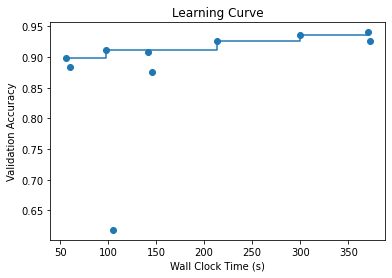

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on FLAML's documentation website https://microsoft.github.io/FLAML/docs/Examples/AutoML-NLP):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content;
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition;
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below;
- (abstractive) summarization: generating the textual summarization of an input paragraph;

For each task, you only have to change the "Load data and preprocess" with the corresponding data loading process. For example:

### 3.1 Multiple Choice Example

Multiple choice is a task of predicting the best second half of a sentence that follows the first half based on common sense reasoning. An example of multiple-choice classification problem is:

On stage, a woman takes a seat at the piano. She
a) sits on a bench as her sister plays with the doll.
b) smiles with someone as the music plays.
c) is in the crowd, watching the dancers.
d) *nervously sets her fingers on the keys*.

In [12]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas().iloc[:10000]
dev_dataset = load_dataset("swag", split="validation").to_pandas().iloc[:10000]
test_dataset = load_dataset("swag", split="test").to_pandas()

custom_sent_keys = [
        "sent1",
        "sent2",
        "ending0",
        "ending1",
        "ending2",
        "ending3",
        "gold-source",
        "video-id",
        "startphrase",
        "fold-ind",
    ]                                                  # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


In [7]:
train_dataset.iloc[0]["sent1"]

'Members of the procession walk down the street holding small horn brass instruments.'

In [13]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,                 # setting the time budget
    "task": "multichoice-classification",       # setting the task as multiplechoice-classification
    "fit_kwargs_by_estimator": {          # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "ckpt_per_epoch": 1,           # setting the number of checkoints per epoch
            "per_device_eval_batch_size": 16, # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86157) {'eval_loss': 0.6315866112709045, 'eval_automl_metric': 0.18779999999999997, 'eval_runtime': 15.4883, 'eval_samples_per_second': 645.648, 'eval_steps_per_second': 40.353, 'epoch': 1.66}
(train pid=86157) {'train_runtime': 190.7625, 'train_samples_per_second': 87.254, 'train_steps_per_second': 10.909, 'train_loss': 0.5091343906738046, 'epoch': 1.66}
(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.2585, 'eval_samples_per_second': 655.374, 'eval_steps_per_second': 40.961, 'epoch': 2.87}


(train pid=86157) Using amp half precision backend
(train pid=86157) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source. If ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86157) ***** Running Prediction *****
(train pid=86157)   Num examples = 10000
(train pid=86157)   Batch size = 16


(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.1369, 'eval_samples_per_second': 660.639, 'eval_steps_per_second': 41.29, 'epoch': 2.87}
(train pid=86249) {'train_runtime': 546.3809, 'train_samples_per_second': 156.658, 'train_steps_per_second': 39.165, 'train_loss': 0.5030154804349909, 'epoch': 2.87}
(train pid=86195) {'loss': 0.4854, 'learning_rate': 1.3592147782116173e-06, 'epoch': 2.0}


(train pid=86249) Using amp half precision backend
(train pid=86249) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3. If fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3 are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86249) ***** Running Prediction *****
(train pid=86249)   Num examples = 10000
(train pid=86249)   Batch size = 16


(train pid=86195) {'eval_loss': 0.49709731340408325, 'eval_automl_metric': 0.17600000000000005, 'eval_runtime': 15.4983, 'eval_samples_per_second': 645.232, 'eval_steps_per_second': 40.327, 'epoch': 2.0}


2022-03-19 14:41:56,719	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254333019256592, 'eval_automl_metric': 0.17800000000000005, 'eval_runtime': 15.45, 'eval_samples_per_second': 647.251, 'eval_steps_per_second': 40.453, 'epoch': 3.0}
(train pid=86195) {'loss': 0.3989, 'learning_rate': 3.8051750127352887e-07, 'epoch': 3.0}


2022-03-19 14:42:56,729	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254867076873779, 'eval_automl_metric': 0.17789999999999995, 'eval_runtime': 15.424, 'eval_samples_per_second': 648.341, 'eval_steps_per_second': 40.521, 'epoch': 3.0}
(train pid=86195) {'eval_loss': 0.5332269072532654, 'eval_automl_metric': 0.17830000000000001, 'eval_runtime': 15.4452, 'eval_samples_per_second': 647.45, 'eval_steps_per_second': 40.466, 'epoch': 3.39}
(train pid=86195) {'train_runtime': 382.2827, 'train_samples_per_second': 88.597, 'train_steps_per_second': 11.076, 'train_loss': 0.5299136270370808, 'epoch': 3.39}


2022-03-19 14:43:56,739	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86195) Using amp half precision backend
(train pid=86195) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind. If ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86195) ***** Running Prediction *****
(train pid=86195)   Num examples = 10000
(train pid=86195)   Batch size = 16
2022-03-19 14:44:14,271	INFO tune.py:639 -- Total run time: 795.18 seconds (504.18 seconds for the tuning loop).
[flaml.automl: 03-19 14:44:19] {2837} INFO - selected model: None
/data/installation/anaconda3/envs/tmp/lib

{'loss': 0.6603, 'learning_rate': 4.631567529441369e-06, 'epoch': 1.0}


[flaml.automl: 03-19 14:46:08] {2947} INFO - retrain transformer for 109.2s
[flaml.automl: 03-19 14:46:08] {2954} INFO - retrained model: None
[flaml.automl: 03-19 14:46:08] {2283} INFO - fit succeeded
[flaml.automl: 03-19 14:46:08] {2284} INFO - Time taken to find the best model: 319.927033662796


{'train_runtime': 96.899, 'train_samples_per_second': 245.031, 'train_steps_per_second': 30.63, 'train_loss': 0.6602518278346073, 'epoch': 1.0}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, '

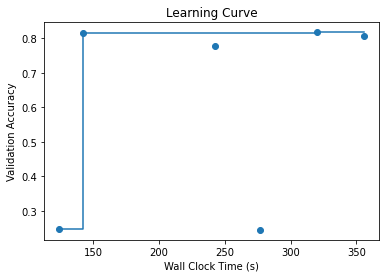

In [14]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 3.2 Text Summarization Example

The text summarization task summarizes a long text into a short sentence. For example:

- Document: Army explosives experts were called out to deal with a suspect package at the offices on the Newtownards Road on Friday night. Roads were sealed off and traffic diverted as a controlled explosion was carried out. The premises, used by East Belfast MP Naomi Long, have been targeted a number of times. Most recently, petrol bomb attacks were carried out on the offices on consecutive nights in April and May. The attacks began following a Belfast City Council vote in December 2012 restricting the flying of the union flag at the City Hall. Condemning the latest hoax, Alliance MLA Chris Lyttle said: "It is a serious incident for the local area, it causes serious disruption, it puts people's lives at risk, it can prevent emergency services reaching the area. "Ultimately we need people with information to share that with the police in order for them to do their job and bring these people to justice.

- Summary: A suspicious package left outside an Alliance Party office in east Belfast has been declared a hoax.

In this example, we use FLAML to perform *abstractive summarization* using the t5-small language model, i.e., the summary is generated word-by-word. 

In [15]:
from datasets import load_dataset

train_dataset = load_dataset("xsum", split="train").to_pandas()
print(len(train_dataset))
dev_dataset = load_dataset("xsum", split="validation").to_pandas()
test_dataset = load_dataset("xsum", split="test").to_pandas()

custom_sent_keys = ["document"]       # specify the column names of the input sentences
label_key = "summary"                 # specify the column name of the label                              

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


204045


Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)
Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


In [16]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,         # setting the time budget
    "task": "summarization",    # setting the task as summarization
    "fit_kwargs_by_estimator": {  # if model_path is not set, the default model is t5-small: https://huggingface.co/t5-small
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "ckpt_per_epoch": 1,    # setting the number of checkoints per epoch
            "model_path": "t5-small",
            "per_device_eval_batch_size": 16,  # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,  # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",  # set the file to save the log for HPO
    "log_type": "all",   # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},  # set whether to use Ray
    "metric": "rouge1",
    "n_concurrent_trials": 4,  # sample: False # if the time is sufficient (e.g., longer than one trial's running time), you can set 
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86232) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86232)   warnings.warn(


(train pid=86232) {'loss': 8.7635, 'learning_rate': 1.2308416834153697e-05, 'epoch': 0.11}


(train pid=86184) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86184)   warnings.warn(
(train pid=86225) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86225)   warnings.warn(
(train pid=86160) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.opti

(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 102.2734, 'eval_samples_per_second': 110.801, 'eval_steps_per_second': 6.932, 'epoch': 0.11}


2022-03-19 14:57:00,687	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 107.4032, 'eval_samples_per_second': 105.509, 'eval_steps_per_second': 6.601, 'epoch': 0.16}


(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!
(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.2143, 'eval_samples_per_second': 104.718, 'eval_steps_per_second': 6.552, 'epoch': 0.36}


2022-03-19 14:58:00,697	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 109.4667, 'eval_samples_per_second': 103.52, 'eval_steps_per_second': 6.477, 'epoch': 0.38}


(train pid=86232) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86232) [nltk_data]   Package punkt is already up-to-date!


(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 110.7246, 'eval_samples_per_second': 102.344, 'eval_steps_per_second': 6.403, 'epoch': 0.11}
(train pid=86232) {'train_runtime': 220.8946, 'train_samples_per_second': 4.648, 'train_steps_per_second': 0.149, 'train_loss': 8.763471198804451, 'epoch': 0.11}


2022-03-19 14:59:00,706	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86232) Using amp half precision backend
(train pid=86232) ***** Running Prediction *****
(train pid=86232)   Num examples = 11332
(train pid=86232)   Batch size = 16
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!
(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 109.1975, 'eval_samples_per_second': 103.775, 'eval_steps_per_second': 6.493, 'epoch': 0.16}


(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'train_runtime': 232.9303, 'train_samples_per_second': 10.067, 'train_steps_per_second': 1.262, 'train_loss': 9.880440506280637, 'epoch': 0.16}
(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.3182, 'eval_samples_per_second': 104.618, 'eval_steps_per_second': 6.546, 'epoch': 0.36}
(train pid=86160) {'train_runtime': 232.4568, 'train_samples_per_second': 92.218, 'train_steps_per_second': 2.887, 'train_loss': 11.215172903878349, 'epoch': 0.36}
(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 110.526, 'eval_samples_per_second': 102.528, 'eval_steps_per_second': 6.415, 'epoch': 0.38}
(train pid=86225) {'train_runtime': 236.6253, 'train_samples_per_second': 19.714, 'train_steps_per_second': 0.621, 'train_loss': 11.549961930614407, 'epoch': 0.38}


2022-03-19 15:00:00,942	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) Using amp half precision backend
(train pid=86184) ***** Running Prediction *****
(train pid=86184)   Num examples = 11332
(train pid=86184)   Batch size = 16
(train pid=86160) Using amp half precision backend
(train pid=86160) ***** Running Prediction *****
(train pid=86160)   Num examples = 11332
(train pid=86160)   Batch size = 16
(train pid=86225) Using amp half precision backend
(train pid=86225) ***** Running Prediction *****
(train pid=86225)   Num examples = 11332
(train pid=86225)   Batch size = 16
2022-03-19 15:01:00,948	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
2022-03-19 15:02:20,150	INFO tune.py:639 -- Total run time: 950.87 seconds (500.36 seconds for the tuning loop).
[flaml.automl: 03-19 15:02:25] {

{'train_runtime': 14.6848, 'train_samples_per_second': 13894.959, 'train_steps_per_second': 434.258, 'train_loss': 10.199760437011719, 'epoch': 0.02}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, '

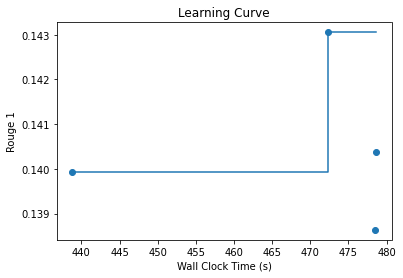

In [17]:

from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Rouge 1')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [18]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(["Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.\nThe Welsh Government said more people than ever were getting help to address housing problems.\nChanges to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.\nPrison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.\nHowever, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.\nAndrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need for accommodation was 'chronic'.\n'There\'s a desperate need for it, finding suitable accommodation for those leaving prison there is just a lack of it everywhere,' he said.\n'It could take six months to a year, without a lot of help they could be on the streets for six months.\n'When you think of the consequences of either being on the street, especially with the cold weather at the moment or you may have a roof over your head, sometimes there is only one choice.'\nMr Stevens believes building more one-bedroom flats could help ease the problem.\n'The average price is a hundred pounds a week to keep someone in a rented flat, prison is a lot more than that so I would imagine it would save the public purse quite a few pounds,' he said.\nOfficial figures show 830 one-bedroom properties were built in the year to March 2016, of an overall total of 6,900 new properties in Wales.\nMarc, 50, who has been in and out of prison for the past 20 years for burglary offences, said he struggled to find accommodation each time he was released.\nHe said he would ask himself: 'Where am I going to stay? Where am I going to live? Have I got somewhere where I can see my daughter.'\n'You\'re put out among the same sort of people doing the same sort of thing, and it\'s difficult, it\'s difficult to get away from it. It\'s like every man for himself, there\'s nothing.'\nMarc has now found stable accommodation with homeless charity Emmaus and said it had been life changing.\n'You feel safe, you got hot food, you\'ve got company of people in similar situations to yourself but all dealing with different issues. It\'s a constructive, helpful atmosphere,' he said.\nTom Clarke, chief executive of Emmaus South Wales, agreed there was not enough support available.\n'We do still see [people] homeless on the streets, so clearly they haven\'t got accommodation and haven\'t got provision,' he said.\n'I think the key is connecting people with the services they need. I don\'t delude myself that Emmaus can offer a one size fits all for everyone, we can\'t.\n'But there must be other opportunities and given suitable encouragement I believe that can and should happen.'\nA Welsh Government spokesman said the national pathway for homeless services to children, young people and adults in the secure estate had prevented many people from losing their home whilst serving their prison sentence.\nIt added there were already significant demands for one-bedroom flats across the public and private sector and it was providing 20,000 new affordable homes in the next five years."])
print('Predicted labels', y_pred)

Using amp half precision backend
***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Predicted labels ['prison link Cymru said some ex-offenders were living rough for up to ']
